# Start with Tensorflow

Jumping off point: https://github.com/filipefborba/HandRecognition
 
Kept their data loader (with minor changes), changed model and eval

In [ ]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download gti-upm/leapgestrecog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 2.13G/2.13G [01:48<00:00, 22.0MB/s]
100% 2.13G/2.13G [01:48<00:00, 21.1MB/s]


## Loading Data

This project uses the [Hand Gesture Recognition Database](https://www.kaggle.com/gti-upm/leapgestrecog/version/1) (citation below) available on Kaggle. It contains 20000 images with different hands and hand gestures. There is a total of 10 hand gestures of 10 different people presented in the dataset. There are 5 female subjects and 5 male subjects.
The images were captured using the Leap Motion hand tracking device.

>Hand Gesture | Label used
>--- | ---
> Thumb down | 0
> Palm (Horizontal) | 1
> L | 2
> Fist (Horizontal) | 3
> Fist (Vertical) | 4
> Thumbs up | 5
> Index | 6
> OK | 7
> Palm (Vertical) | 8
> C | 9

Table 1 - Classification used for every hand gesture.


T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)  

Overview:
- Load images
- Some validation
- Preparing the images for training
- Use of train_test_split

In [ ]:
# Unzip images, ignore this cell if files are already in the workspace
!unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [ ]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk('/content/leapGestRecog'): 
  print(root)
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

/content/leapGestRecog
/content/leapGestRecog/05
/content/leapGestRecog/05/09_c
/content/leapGestRecog/05/04_fist_moved
/content/leapGestRecog/05/08_palm_moved
/content/leapGestRecog/05/07_ok
/content/leapGestRecog/05/02_l
/content/leapGestRecog/05/05_thumb
/content/leapGestRecog/05/10_down
/content/leapGestRecog/05/06_index
/content/leapGestRecog/05/03_fist
/content/leapGestRecog/05/01_palm
/content/leapGestRecog/03
/content/leapGestRecog/03/09_c
/content/leapGestRecog/03/04_fist_moved
/content/leapGestRecog/03/08_palm_moved
/content/leapGestRecog/03/07_ok
/content/leapGestRecog/03/02_l
/content/leapGestRecog/03/05_thumb
/content/leapGestRecog/03/10_down
/content/leapGestRecog/03/06_index
/content/leapGestRecog/03/03_fist
/content/leapGestRecog/03/01_palm
/content/leapGestRecog/06
/content/leapGestRecog/06/09_c
/content/leapGestRecog/06/04_fist_moved
/content/leapGestRecog/06/08_palm_moved
/content/leapGestRecog/06/07_ok
/content/leapGestRecog/06/02_l
/content/leapGestRecog/06/05_thum

In [ ]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


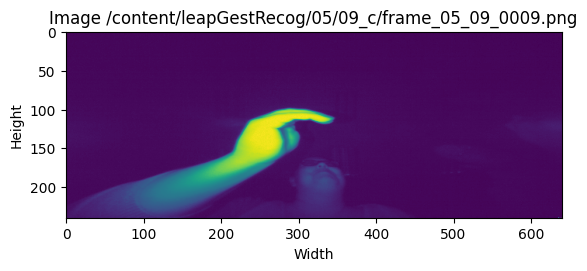

In [ ]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

Now that we loaded the images and checked if it's everything we expected, we have to prepare the images to train the algorithm. We have to load all the images into an array that we will call **X** and all the labels into another array called **y**.

In [ ]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (64, 64)) # Reduce image size so training can be faster
  
  category = path.split("/")[3]
  #print(category, 'categ')
  try:
    # Processing label in image path
    label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
    y.append(label)
    X.append(img)
    #print(label, 'label')
  except:
    break

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(X), 64, 64, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  20000
Labels loaded:  20000
5 /content/leapGestRecog/05/09_c/frame_05_09_0009.png


In [ ]:
print(len(X))

print(len(y))

20000
20000


Scipy's train_test_split allows us to split our data into a training set and a test set. The training set will be used to build our model. Then, the test data will be used to check if our predictions are correct.  A random_state seed is used so the randomness of our results can be reproduced. The function will shuffle the images it's using to minimize training loss.


In [ ]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [ ]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [ ]:
from keras.layers import Dropout

# Construction of model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1))) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))



'''
self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')
'''

"\nself.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))\n        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')\n        self.dropout1 = tf.keras.layers.Dropout(0.25)\n        self.dropout2 = tf.keras.layers.Dropout(0.5)\n        self.fc1 = tf.keras.layers.Dense(128, activation='relu')\n        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')\n"

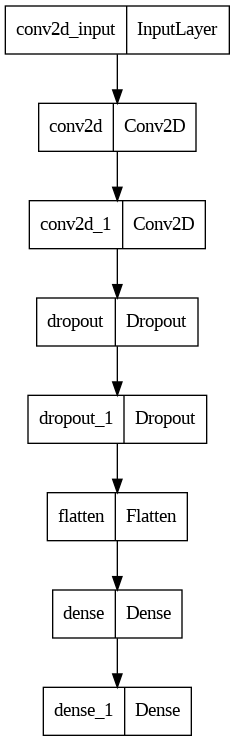

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [ ]:
import time

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.perf_counter()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.perf_counter() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

timetaken = timecallback()

Epoch 1/20
219/219 - 4s - loss: 2.5092 - accuracy: 0.9140 - val_loss: 0.0243 - val_accuracy: 0.9888 - 4s/epoch - 20ms/step
Epoch 2/20
219/219 - 4s - loss: 0.0320 - accuracy: 0.9881 - val_loss: 0.0311 - val_accuracy: 0.9887 - 4s/epoch - 17ms/step
Epoch 3/20
219/219 - 4s - loss: 0.0189 - accuracy: 0.9915 - val_loss: 0.0160 - val_accuracy: 0.9913 - 4s/epoch - 17ms/step
Epoch 4/20
219/219 - 4s - loss: 0.0162 - accuracy: 0.9915 - val_loss: 0.0137 - val_accuracy: 0.9910 - 4s/epoch - 17ms/step
Epoch 5/20
219/219 - 4s - loss: 0.0124 - accuracy: 0.9929 - val_loss: 0.0145 - val_accuracy: 0.9903 - 4s/epoch - 17ms/step
Epoch 6/20
219/219 - 4s - loss: 0.0120 - accuracy: 0.9926 - val_loss: 0.0130 - val_accuracy: 0.9910 - 4s/epoch - 17ms/step
Epoch 7/20
219/219 - 4s - loss: 0.0129 - accuracy: 0.9925 - val_loss: 0.0144 - val_accuracy: 0.9907 - 4s/epoch - 17ms/step
Epoch 8/20
219/219 - 4s - loss: 0.0347 - accuracy: 0.9873 - val_loss: 0.0337 - val_accuracy: 0.9872 - 4s/epoch - 17ms/step
Epoch 9/20
219/2

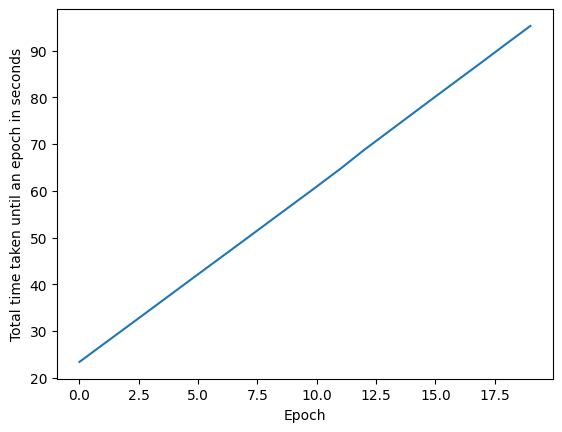

In [ ]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=2, validation_data=(X_test, y_test), callbacks = [timetaken])

In [ ]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

In [ ]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

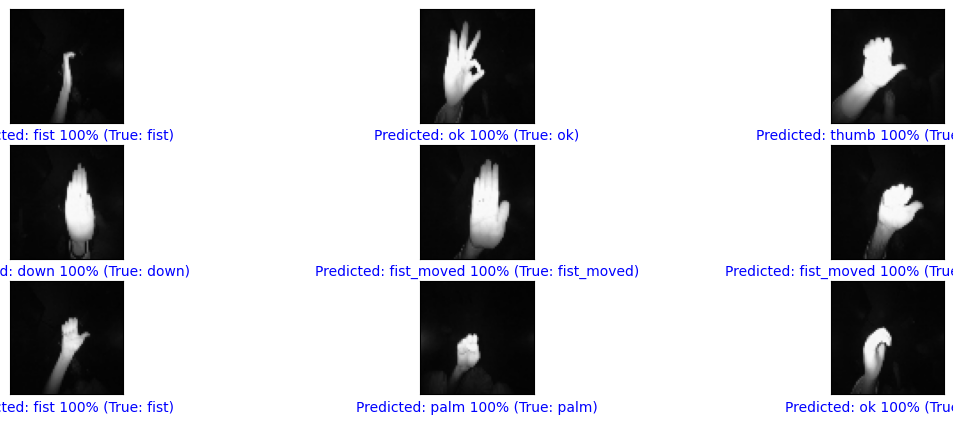

In [ ]:
validate_9_images(predictions, y_test, X_test)

# Now Pytorch

Jumping off point: https://www.kaggle.com/code/rajgupt/pytorch-sign-detector-basic

In [ ]:
#for optimal (WandB)
bs = 32
lr = 0.0059


'\n#for optimal (WandB)\nbs = 32\nlr = 0.0059\n'

In [ ]:
import numpy as np
import pandas as pd
import sys, os
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# debugger for handling errors
from IPython.core.debugger import set_trace

In [ ]:
class SIGNSDataset(Dataset):
    def __init__(self, filenames, labels, transform):      
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        #open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
train_transformer = transforms.Compose([
                    transforms.Resize(64),              # resize the image to 64x64 
                    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
                    transforms.ToTensor()])             # transform it into a PyTorch Tensor

val_transformer =   transforms.Compose([
                    transforms.Resize(64),              # resize the image to 64x64 
                    transforms.ToTensor()])             # transform it into a PyTorch Tensor

In [ ]:
import glob
images = glob.glob('/content/leapGestRecog/**/**/*.png')

# extract label number from filename and reduce by 1 so that it ranges from 0 to 9 (instead of 1 to 10). Otherwise loss function will complain
labels = [int(os.path.basename(i).split('_')[2])-1 for i in images]
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
train_dataset = SIGNSDataset(x_train, y_train, train_transformer)
val_dataset = SIGNSDataset(x_val, y_val, val_transformer)

In [ ]:
len(train_dataset)
len(val_dataset)

4000

In [ ]:
train_dl = DataLoader(train_dataset, bs, shuffle=True)
val_dl = DataLoader(val_dataset, bs)

In [ ]:
# Model Arch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25) #change to 0.49 for optimal
        self.dropout2 = nn.Dropout2d(0.5) #change to 0.49 for optimal
        self.fc1 = nn.Linear(79680, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
import numpy as np
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time

def get_model():
    model = Net().to(device)
    return model, optim.SGD(model.parameters(), lr=lr)


def loss_batch(model, loss_func, xb, yb, opt=None):
    yhat = model(xb.to(device))
    loss = loss_func(yhat.to(device), yb.to(device))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        start = time.perf_counter()
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb.to(device), yb.to(device), opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss, time.perf_counter()-start)

model, opt = get_model()
loss_func = F.cross_entropy

In [ ]:
fit(5, model, loss_func, opt, train_dl, val_dl)

0 0.022148465184727684 50.35004065599969
1 0.02854018245730549 49.94511377700019
2 0.016426096902694552 50.26518873300029
3 0.01724422780959867 50.054356374000236
4 0.016665803605224936 50.021033347999946


In [ ]:
def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total


In [ ]:
score = test(model, val_dl)
print(score)

99.325


In [ ]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [ ]:
net_q2 = copy_model(model)

In [ ]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    
    '''
    # ADD YOUR CODE HERE

    #going from 32-bit to 8-bit
    n=8

    #using the formula from the slides. as mentioned in OH with the Prof, we may treat step size and 
    #scale as synonymous.
    scale = ((pow(2,n)-1)/2)/(torch.max(abs(weights)))
    

    result = (weights * scale).round()
    return torch.clamp(result, min=-128, max=127), scale

In [ ]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [ ]:

score = test(net_q2, val_dl)
print(score)

99.2


### Access W&B Report Here:
https://api.wandb.ai/links/hpmlfinalproj/hau1iwe9

In [ ]:
!pip uninstall wandb

In [ ]:
!pip install wandb -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

In [ ]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict={
    'dropout': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.2,
        'max': 0.5
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      },
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    }
sweep_config['parameters'] = parameters_dict


In [ ]:
# Model Arch
class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, 3, 1)
            self.conv2 = nn.Conv2d(32, 32, 3, 1)
            self.dropout1 = nn.Dropout2d(dropout)
            self.dropout2 = nn.Dropout2d(dropout)
            self.fc1 = nn.Linear(79680, 128)
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = self.dropout1(x)
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.dropout2(x)
            x = self.fc2(x)
            output = F.log_softmax(x, dim=1)
            return output

In [ ]:
import numpy as np
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time


def get_model():
    model = Net().to(device)
    return model, optim.SGD(model.parameters(), lr=learning_rate)


def loss_batch(model, loss_func, xb, yb, opt=None):
    yhat = model(xb.to(device))
    loss = loss_func(yhat.to(device), yb.to(device))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(4):
        print('epoch', epoch)
        start = time.perf_counter()
        model.train()
        #print('train done')
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb.to(device), yb.to(device), opt)
        #print('loss done')
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        #print('eval done')
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss, time.perf_counter()-start)
    #print('inside loss', val_loss)
    return val_loss


In [ ]:
from keras.callbacks import learning_rate_schedule
def train_sweep(config=None):
  with wandb.init(config=config):

    config = wandb.config
    # Configure training/optimization
    global dropout
    global learning_rate
    dropout = config.dropout
    batch_size = config.batch_size
    learning_rate = config.learning_rate

    train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, batch_size)

    
    model, opt = get_model()
    loss_func = F.cross_entropy

    loss = fit(1, model, loss_func, opt, train_dl, val_dl)
    print('outside loss', loss)
    iteration = 1
    wandb.log({"loss": loss, "epoch": iteration})        

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

Create sweep with ID: lughqs7f
Sweep URL: https://wandb.ai/hpmlfinalproj/pytorch-sweeps-demo/sweeps/lughqs7f


In [ ]:
wandb.agent(sweep_id, train_sweep, count=50)

wandb: Agent Starting Run: xmjx71ik with config:
wandb: 	batch_size: 136
wandb: 	dropout: 0.33470266499632173
wandb: 	learning_rate: 0.030211939695412283
wandb: Currently logged in as: yc3991 (hpmlfinalproj). Use `wandb login --relogin` to force relogin


epoch 0


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0 1.435416744709015 61.17881401900013
epoch 1
1 0.7344924584627152 52.59863439599985
epoch 2
2 0.31418169984221456 52.46725209600004
epoch 3
3 0.3808677622973919 52.66831393999996
outside loss 0.3808677622973919


epoch,▁
loss,▁
epoch,1
loss,0.38087


wandb: Agent Starting Run: 0fvqzaby with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2806283704585494
wandb: 	learning_rate: 0.07291613478232893


epoch 0
0 0.6457738547325135 52.62134743799993
epoch 1
1 0.20841126906871796 52.93743101600012
epoch 2
2 0.07377112439274788 53.10806705999994
epoch 3
3 0.049864333160221576 53.13858603300014
outside loss 0.049864333160221576


epoch,▁
loss,▁
epoch,1
loss,0.04986


wandb: Agent Starting Run: ax08iz4y with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.30159079233096986
wandb: 	learning_rate: 0.08271979957809883


epoch 0
0 0.4926025640964508 53.35812058900001
epoch 1
1 0.10188417330384254 52.662799062999966
epoch 2
2 0.03919843090698123 51.79576549199987
epoch 3
3 0.017669607443967835 51.22329269700003
outside loss 0.017669607443967835


epoch,▁
loss,▁
epoch,1
loss,0.01767


wandb: Agent Starting Run: o44cqxn8 with config:
wandb: 	batch_size: 216
wandb: 	dropout: 0.23361675687246228
wandb: 	learning_rate: 0.02017724832531187


epoch 0
0 2.060769327878952 47.34779576999995
epoch 1
1 1.299062477350235 46.91538120900009
epoch 2
2 1.2687542412281037 47.19026241000006
epoch 3
3 0.9424243955612183 47.26287629800004
outside loss 0.9424243955612183


epoch,▁
loss,▁
epoch,1
loss,0.94242


wandb: Agent Starting Run: 2wl57lc3 with config:
wandb: 	batch_size: 208
wandb: 	dropout: 0.43913266435762544
wandb: 	learning_rate: 0.010469960936092973


epoch 0
0 2.1345830612182617 47.45297819699999
epoch 1
1 1.5401224517822265 47.50730434700017
epoch 2
2 1.247331919670105 47.84206862799988
epoch 3
3 1.054874667406082 48.15795472400009
outside loss 1.054874667406082


epoch,▁
loss,▁
epoch,1
loss,1.05487


wandb: Agent Starting Run: 60y8sp84 with config:
wandb: 	batch_size: 56
wandb: 	dropout: 0.35456209756773704
wandb: 	learning_rate: 0.03455023759831879


epoch 0
0 0.7434302779436112 50.812064732999715
epoch 1
1 0.3428517208695412 50.7963334039996
epoch 2
2 0.12492742008715868 50.62470042799987
epoch 3
3 0.11123911745101213 50.52632118099973
outside loss 0.11123911745101213


epoch,▁
loss,▁
epoch,1
loss,0.11124


wandb: Agent Starting Run: de7b23fm with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.36505131572142546
wandb: 	learning_rate: 0.030649813403691252


epoch 0
0 0.7004422979354858 51.00237063199984
epoch 1
1 0.26168013918399813 50.487920309999936
epoch 2
2 0.14757505044341088 50.63049528500005
epoch 3
3 0.0786386176943779 50.60696774300004
outside loss 0.0786386176943779


epoch,▁
loss,▁
epoch,1
loss,0.07864


wandb: Agent Starting Run: wh5dosg9 with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.215910685830291
wandb: 	learning_rate: 0.08003899499971098


epoch 0
0 0.6431664404273033 50.72662351700001
epoch 1
1 0.09808787146583199 50.83241538399989
epoch 2
2 0.04348097783979028 50.676487799999904
epoch 3
3 0.048054782401304695 50.69961923200026
outside loss 0.048054782401304695


epoch,▁
loss,▁
epoch,1
loss,0.04805


wandb: Agent Starting Run: dig0qmqp with config:
wandb: 	batch_size: 184
wandb: 	dropout: 0.30927897746299354
wandb: 	learning_rate: 0.0348095626976923


epoch 0
0 1.2305449330806733 48.524875687000076
epoch 1
1 0.6416013376712799 48.28545444600013
epoch 2
2 0.508311782836914 48.173138271000425
epoch 3
3 0.3198023420870304 48.032490243999746
outside loss 0.3198023420870304


epoch,▁
loss,▁
epoch,1
loss,0.3198


wandb: Agent Starting Run: q92wzg3g with config:
wandb: 	batch_size: 88
wandb: 	dropout: 0.3708841817258423
wandb: 	learning_rate: 0.07313915884410502


epoch 0
0 1.1245178126096727 49.96403446799968
epoch 1
1 0.48095402216911315 50.165372103999744
epoch 2
2 0.20205855563282968 50.01415396500033
epoch 3
3 0.13213661547750236 50.10165772499977
outside loss 0.13213661547750236


epoch,▁
loss,▁
epoch,1
loss,0.13214


wandb: Agent Starting Run: x88odult with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.2877635893148192
wandb: 	learning_rate: 0.07477964783649431


epoch 0
0 0.4376505661010742 50.381820264
epoch 1
1 0.0907448347657919 51.19312584099998
epoch 2
2 0.040694166356697675 50.40574790200026
epoch 3
3 0.017960626585409045 50.828358324999954
outside loss 0.017960626585409045


epoch,▁
loss,▁
epoch,1
loss,0.01796


wandb: Agent Starting Run: kzddmlxf with config:
wandb: 	batch_size: 184
wandb: 	dropout: 0.2955180139557336
wandb: 	learning_rate: 0.09450846924717772


epoch 0
0 1.2250764653682709 48.4555457649999
epoch 1
1 0.8793327969312668 48.91854636399967
epoch 2
2 0.562058836221695 48.841868417000114
epoch 3
3 0.34006985914707183 48.48220071800006
outside loss 0.34006985914707183


epoch,▁
loss,▁
epoch,1
loss,0.34007


wandb: Agent Starting Run: ro3s4xqa with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.23963411996724407
wandb: 	learning_rate: 0.09694735997160572


epoch 0
0 1.1557287425994873 50.17805213099973
epoch 1
1 0.6552010135650634 50.10868718499978
epoch 2
2 0.2018889627456665 50.34567756499973
epoch 3
3 0.0741088057756424 49.92773156500016
outside loss 0.0741088057756424


epoch,▁
loss,▁
epoch,1
loss,0.07411


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uwtpi7to with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3297769693484812
wandb: 	learning_rate: 0.033756383517061665


epoch 0
0 0.7288671479225158 50.41389447599977
epoch 1
1 0.3008727385997772 50.24690686699978
epoch 2
2 0.13318719774484633 50.09828970599983
epoch 3
3 0.10668069702386856 50.063159968000036
outside loss 0.10668069702386856


epoch,▁
loss,▁
epoch,1
loss,0.10668


wandb: Agent Starting Run: vk95zsrx with config:
wandb: 	batch_size: 48
wandb: 	dropout: 0.4353204650649186
wandb: 	learning_rate: 0.05770444030991392


epoch 0
0 1.043110990524292 50.516634263000014
epoch 1
1 0.30980097913742066 50.56269492199999
epoch 2
2 0.12845151419937612 50.44781875599983
epoch 3
3 0.05264966153167188 50.49848014899999
outside loss 0.05264966153167188


epoch,▁
loss,▁
epoch,1
loss,0.05265


wandb: Agent Starting Run: z9xsch8a with config:
wandb: 	batch_size: 144
wandb: 	dropout: 0.21075385976941877
wandb: 	learning_rate: 0.0963055773552082


epoch 0
0 1.4916286444664002 50.11881059899952
epoch 1
1 0.7641548306941987 50.03882461000012
epoch 2
2 0.6640929553508759 50.135430498999995
epoch 3
3 0.3008375379443169 49.7838045160006
outside loss 0.3008375379443169


epoch,▁
loss,▁
epoch,1
loss,0.30084


wandb: Agent Starting Run: ewof5c4i with config:
wandb: 	batch_size: 152
wandb: 	dropout: 0.22558865702562897
wandb: 	learning_rate: 0.06049665757246889


epoch 0
0 1.3916601498126984 49.89087715500045
epoch 1
1 1.1534065234661102 49.803609285000675
epoch 2
2 0.5288285112380982 50.0046336839996
epoch 3
3 0.3272401940822601 49.91262952299985
outside loss 0.3272401940822601


epoch,▁
loss,▁
epoch,1
loss,0.32724


wandb: Agent Starting Run: o17jwrcp with config:
wandb: 	batch_size: 224
wandb: 	dropout: 0.23920311164686747
wandb: 	learning_rate: 0.048083911829027305


epoch 0
0 1.6294881896972657 47.29258875300002
epoch 1
1 0.8529451689720153 47.37624021699958
epoch 2
2 0.653519054889679 47.31474763599999
epoch 3
3 0.5065967755317689 47.04264363200036
outside loss 0.5065967755317689


epoch,▁
loss,▁
epoch,1
loss,0.5066


wandb: Agent Starting Run: 9bkkh885 with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.29241014319147585
wandb: 	learning_rate: 0.08508983373559674


epoch 0
0 0.3673102558404207 50.55925130000014
epoch 1
1 0.060568945063278076 50.95166724400042
epoch 2
2 0.02932966008025687 50.567545116000474
epoch 3
3 0.012148704139981419 50.54305369800022
outside loss 0.012148704139981419


epoch,▁
loss,▁
epoch,1
loss,0.01215


wandb: Agent Starting Run: fhs2dfmo with config:
wandb: 	batch_size: 160
wandb: 	dropout: 0.24651176508007
wandb: 	learning_rate: 0.09299385985548332


epoch 0
0 1.3727804851531982 49.418700311000066
epoch 1
1 0.7244379234313965 49.383713172999705
epoch 2
2 0.5674031960964203 49.17483224100033
epoch 3
3 0.3088035815954208 49.6176131860002
outside loss 0.3088035815954208


epoch,▁
loss,▁
epoch,1
loss,0.3088


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ktj4o1pt with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.22074815035603104
wandb: 	learning_rate: 0.09938567173731896


epoch 0
0 0.3751091518998146 51.737734194999575
epoch 1
1 0.043864676393568516 50.72770831499929
epoch 2
2 0.018233001944608987 50.83271519099981
epoch 3
3 0.009487539945257594 50.61061087200051
outside loss 0.009487539945257594


epoch,▁
loss,▁
epoch,1
loss,0.00949


wandb: Agent Starting Run: v5oee1nq with config:
wandb: 	batch_size: 136
wandb: 	dropout: 0.4257696141074041
wandb: 	learning_rate: 0.056136884452431625


epoch 0
0 1.199120281457901 50.35916392499985
epoch 1
1 0.7804625157117844 50.42268351199982
epoch 2
2 0.4571532783508301 50.37604483999985
epoch 3
3 0.2926743418574333 50.26093456499984
outside loss 0.2926743418574333


epoch,▁
loss,▁
epoch,1
loss,0.29267


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2doy7kme with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3456299666426563
wandb: 	learning_rate: 0.04516197354055576


epoch 0
0 0.9734652466773986 50.57507553300002
epoch 1
1 0.4180235624313354 50.45645810699989
epoch 2
2 0.16809744346141814 50.67450598300002
epoch 3
3 0.15937182742357253 50.60788518299978
outside loss 0.15937182742357253


epoch,▁
loss,▁
epoch,1
loss,0.15937


wandb: Agent Starting Run: x8vtevcr with config:
wandb: 	batch_size: 88
wandb: 	dropout: 0.4244948750331275
wandb: 	learning_rate: 0.03589995124239936


epoch 0
0 0.9718262895345687 50.51259547399968
epoch 1
1 0.4091216034889221 50.730853977999686
epoch 2
2 0.24893507555127145 50.60340426499988
epoch 3
3 0.12306488539278507 50.8999718139994
outside loss 0.12306488539278507


epoch,▁
loss,▁
epoch,1
loss,0.12306


wandb: Agent Starting Run: heh5t4g5 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4917064549752313
wandb: 	learning_rate: 0.05898327232022112


epoch 0
0 0.6411928815841674 51.0497914739999
epoch 1
1 0.1479966617077589 50.87576168800024
epoch 2
2 0.05854336815699935 50.818476171999464
epoch 3
3 0.029689825447276233 50.77083339799992
outside loss 0.029689825447276233


epoch,▁
loss,▁
epoch,1
loss,0.02969


wandb: Agent Starting Run: d1b7wvrr with config:
wandb: 	batch_size: 120
wandb: 	dropout: 0.3658418022661516
wandb: 	learning_rate: 0.06626665014363141


epoch 0
0 1.242618955373764 50.33319011000003
epoch 1
1 0.8759109985828399 50.36288897600025
epoch 2
2 1.0101785135269166 50.34685923399957
epoch 3
3 0.20739686861634254 50.344746636999844
outside loss 0.20739686861634254


epoch,▁
loss,▁
epoch,1
loss,0.2074


wandb: Agent Starting Run: 0cm6ikgx with config:
wandb: 	batch_size: 208
wandb: 	dropout: 0.4923985773334644
wandb: 	learning_rate: 0.036390986031644194


epoch 0
0 1.5551964683532715 47.6985863230002
epoch 1
1 0.967367778301239 47.7547014970005
epoch 2
2 0.7381590523719788 47.74744243100031
epoch 3
3 0.4512377541065216 48.052469301999736
outside loss 0.4512377541065216


epoch,▁
loss,▁
epoch,1
loss,0.45124


wandb: Agent Starting Run: 4nm4rfpr with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.21015778842547084
wandb: 	learning_rate: 0.06257879275016441


epoch 0
0 1.5431007013320923 50.63168642399978
epoch 1
1 0.7910753593444825 50.35090534899973
epoch 2
2 0.27058983850479124 50.123936872999366
epoch 3
3 0.3356845796108246 50.35240961999989
outside loss 0.3356845796108246


epoch,▁
loss,▁
epoch,1
loss,0.33568


wandb: Agent Starting Run: 180198bj with config:
wandb: 	batch_size: 104
wandb: 	dropout: 0.2889773441997924
wandb: 	learning_rate: 0.024897216661743927


epoch 0
0 0.967289510846138 50.429651467999975
epoch 1
1 0.7202917757034302 50.7841584859998
epoch 2
2 0.23053914001584053 50.59622647700053
epoch 3
3 0.1867712205350399 50.66607105200001
outside loss 0.1867712205350399


epoch,▁
loss,▁
epoch,1
loss,0.18677


wandb: Agent Starting Run: cz94lpw5 with config:
wandb: 	batch_size: 56
wandb: 	dropout: 0.32544846389497606
wandb: 	learning_rate: 0.07617684682604407


epoch 0
0 0.7249170036911965 50.99309368200011
epoch 1
1 0.14038700333982707 50.70971867800017
epoch 2
2 0.04823120563011617 50.82370026799981
epoch 3
3 0.030989654153119772 50.84455680500014
outside loss 0.030989654153119772


epoch,▁
loss,▁
epoch,1
loss,0.03099


wandb: Agent Starting Run: ecnzajbm with config:
wandb: 	batch_size: 72
wandb: 	dropout: 0.30925087517821737
wandb: 	learning_rate: 0.06198041546602158


epoch 0
0 2.474063569545746 50.82091972099988
epoch 1
1 0.26667070028185846 50.91643663800005
epoch 2
2 0.18883951392769813 50.97003475800011
epoch 3
3 0.09411927544698119 50.86534130200016
outside loss 0.09411927544698119


epoch,▁
loss,▁
epoch,1
loss,0.09412


wandb: Agent Starting Run: jvwez1nc with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.41175290994278496
wandb: 	learning_rate: 0.07199488397974207


epoch 0
0 0.8689963331222534 50.84456227899955
epoch 1
1 0.399085720539093 50.739452236000034
epoch 2
2 0.13294320410490035 50.73670746300013
epoch 3
3 0.06952058815956116 51.14608977899934
outside loss 0.06952058815956116


epoch,▁
loss,▁
epoch,1
loss,0.06952


wandb: Agent Starting Run: wr599rp5 with config:
wandb: 	batch_size: 48
wandb: 	dropout: 0.2754798889856348
wandb: 	learning_rate: 0.0929007703283369


epoch 0
0 0.7391332522630691 51.39521881900055
epoch 1
1 0.0833016262240708 51.43200937200072
epoch 2
2 0.03744912117160857 51.20669630500015
epoch 3
3 0.025097467376152052 50.958446087000084
outside loss 0.025097467376152052


epoch,▁
loss,▁
epoch,1
loss,0.0251


wandb: Agent Starting Run: pireaxts with config:
wandb: 	batch_size: 72
wandb: 	dropout: 0.2909981797901056
wandb: 	learning_rate: 0.038505401952575936


epoch 0
0 1.2619698408842086 50.83484151799894
epoch 1
1 0.2745156148970127 51.267847629000244
epoch 2
2 0.32189217337965964 51.06712445099947
epoch 3
3 0.7039205827713013 51.08824771699983
outside loss 0.7039205827713013


epoch,▁
loss,▁
epoch,1
loss,0.70392


wandb: Agent Starting Run: uchlxs5i with config:
wandb: 	batch_size: 152
wandb: 	dropout: 0.2961759235358612
wandb: 	learning_rate: 0.054782621195926286


epoch 0
0 1.3336557371616364 50.264455754000664
epoch 1
1 1.5032019875049591 50.53006358699895
epoch 2
2 0.561479913532734 50.40818150500127
epoch 3
3 0.4813084437251091 49.83619650699984
outside loss 0.4813084437251091


epoch,▁
loss,▁
epoch,1
loss,0.48131


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xd0jvqnb with config:
wandb: 	batch_size: 48
wandb: 	dropout: 0.31489458846133495
wandb: 	learning_rate: 0.010555018192800235


epoch 0
0 1.2283497562408447 50.720786288000454
epoch 1
1 0.5021507318615913 50.64421514499918
epoch 2
2 0.19205324947834015 50.50750031800089
epoch 3
3 0.371844233751297 50.73071961700043
outside loss 0.371844233751297


epoch,▁
loss,▁
epoch,1
loss,0.37184


wandb: Agent Starting Run: t3rvzjqe with config:
wandb: 	batch_size: 104
wandb: 	dropout: 0.20435196951411333
wandb: 	learning_rate: 0.03373587817170542


epoch 0
0 1.144735237121582 50.12684800699935
epoch 1
1 0.44726630598306655 50.329644932999145
epoch 2
2 0.20841926676034928 50.19655087699903
epoch 3
3 0.11221907625347376 50.34166567600005
outside loss 0.11221907625347376


epoch,▁
loss,▁
epoch,1
loss,0.11222


wandb: Agent Starting Run: zh5bss19 with config:
wandb: 	batch_size: 248
wandb: 	dropout: 0.23073300409541753
wandb: 	learning_rate: 0.02771944353030762


epoch 0
0 1.6165889348983764 47.3283520290006
epoch 1
1 1.001073279619217 47.39460666800005
epoch 2
2 0.6533535575866699 47.64163435299997
epoch 3
3 0.4668989890813828 47.54310688900114
outside loss 0.4668989890813828


epoch,▁
loss,▁
epoch,1
loss,0.4669


wandb: Agent Starting Run: lt8wmo5d with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.34569523453394446
wandb: 	learning_rate: 0.02990130721382167


epoch 0
0 1.2428018732070922 50.24817102899942
epoch 1
1 0.7139093255996705 50.124732615999164
epoch 2
2 0.31764915680885314 50.099327616000664
epoch 3
3 0.21353208434581755 50.22880780699961
outside loss 0.21353208434581755


epoch,▁
loss,▁
epoch,1
loss,0.21353


wandb: Agent Starting Run: 74d2nwxf with config:
wandb: 	batch_size: 88
wandb: 	dropout: 0.49920331483468666
wandb: 	learning_rate: 0.03146532802914211


epoch 0
0 1.1266760787963868 50.34587203299998
epoch 1
1 0.5605536583662033 50.42443576900041
epoch 2
2 0.37073021084070207 50.409829037000236
epoch 3
3 0.22110030061006547 50.241795328998705
outside loss 0.22110030061006547


epoch,▁
loss,▁
epoch,1
loss,0.2211


wandb: Agent Starting Run: gfox28pt with config:
wandb: 	batch_size: 232
wandb: 	dropout: 0.45178439527783126
wandb: 	learning_rate: 0.025398456423046445


epoch 0
0 1.7310607469081878 47.45723016000011
epoch 1
1 1.1364004415273667 47.67075962200033
epoch 2
2 0.9085345478057861 47.82788524499847
epoch 3
3 0.49534140795469284 47.581603054999505
outside loss 0.49534140795469284


epoch,▁
loss,▁
epoch,1
loss,0.49534


wandb: Agent Starting Run: mfjhkiac with config:
wandb: 	batch_size: 88
wandb: 	dropout: 0.26622141632928614
wandb: 	learning_rate: 0.09037115077399144


epoch 0
0 0.9420914194583893 50.586507979998714
epoch 1
1 0.16619775103032589 50.38305730600041
epoch 2
2 0.06670119285210967 50.681298241999684
epoch 3
3 0.05115360267460346 50.457507939001516
outside loss 0.05115360267460346


epoch,▁
loss,▁
epoch,1
loss,0.05115


wandb: Agent Starting Run: oyuy05wj with config:
wandb: 	batch_size: 88
wandb: 	dropout: 0.22265720981130188
wandb: 	learning_rate: 0.01077592555178384


epoch 0
0 1.2640190117359162 50.470717703001355
epoch 1
1 0.823950248003006 50.68643427900133
epoch 2
2 0.2878326667845249 50.4984362539999
epoch 3
3 0.20594686217606067 50.436039894000714
outside loss 0.20594686217606067


epoch,▁
loss,▁
epoch,1
loss,0.20595


wandb: Agent Starting Run: 649w8u0i with config:
wandb: 	batch_size: 144
wandb: 	dropout: 0.4304670157941077
wandb: 	learning_rate: 0.04347062207463821


epoch 0
0 1.5463211317062378 50.49446536300093
epoch 1
1 0.9540916759967804 50.341437809000126
epoch 2
2 0.5835038496255874 50.20301108000058
epoch 3


wandb: Ctrl + C detected. Stopping sweep.
